In [1]:
import random
import numpy as np

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from src.data import load_preprocess_data
from src.experiments import evaluate_feature_selection, perform_feature_selection_on_all_datasets, process_generated_data_results
from src.visualization import plot_all_datasets, plot_n_features_ratio

random.seed(123)
np.random.seed(123)

In [2]:
data = load_preprocess_data()

In [3]:
relevant_features = perform_feature_selection_on_all_datasets(data)

Finding relevant features for divorce dataset...
Calculations completed!
Finding relevant features for aids dataset...
Calculations completed!
Finding relevant features for lol dataset...
Calculations completed!
Finding relevant features for cancer dataset...
Calculations completed!
Finding relevant features for gait dataset...
Calculations completed!
Finding relevant features for generated_0 dataset...
Calculations completed!
Finding relevant features for generated_1 dataset...
Calculations completed!
Finding relevant features for generated_2 dataset...
Calculations completed!
Finding relevant features for xor dataset...
Calculations completed!


Processing dataset xor: 100%|██████████| 6/6 [00:00<00:00, 28.80it/s]


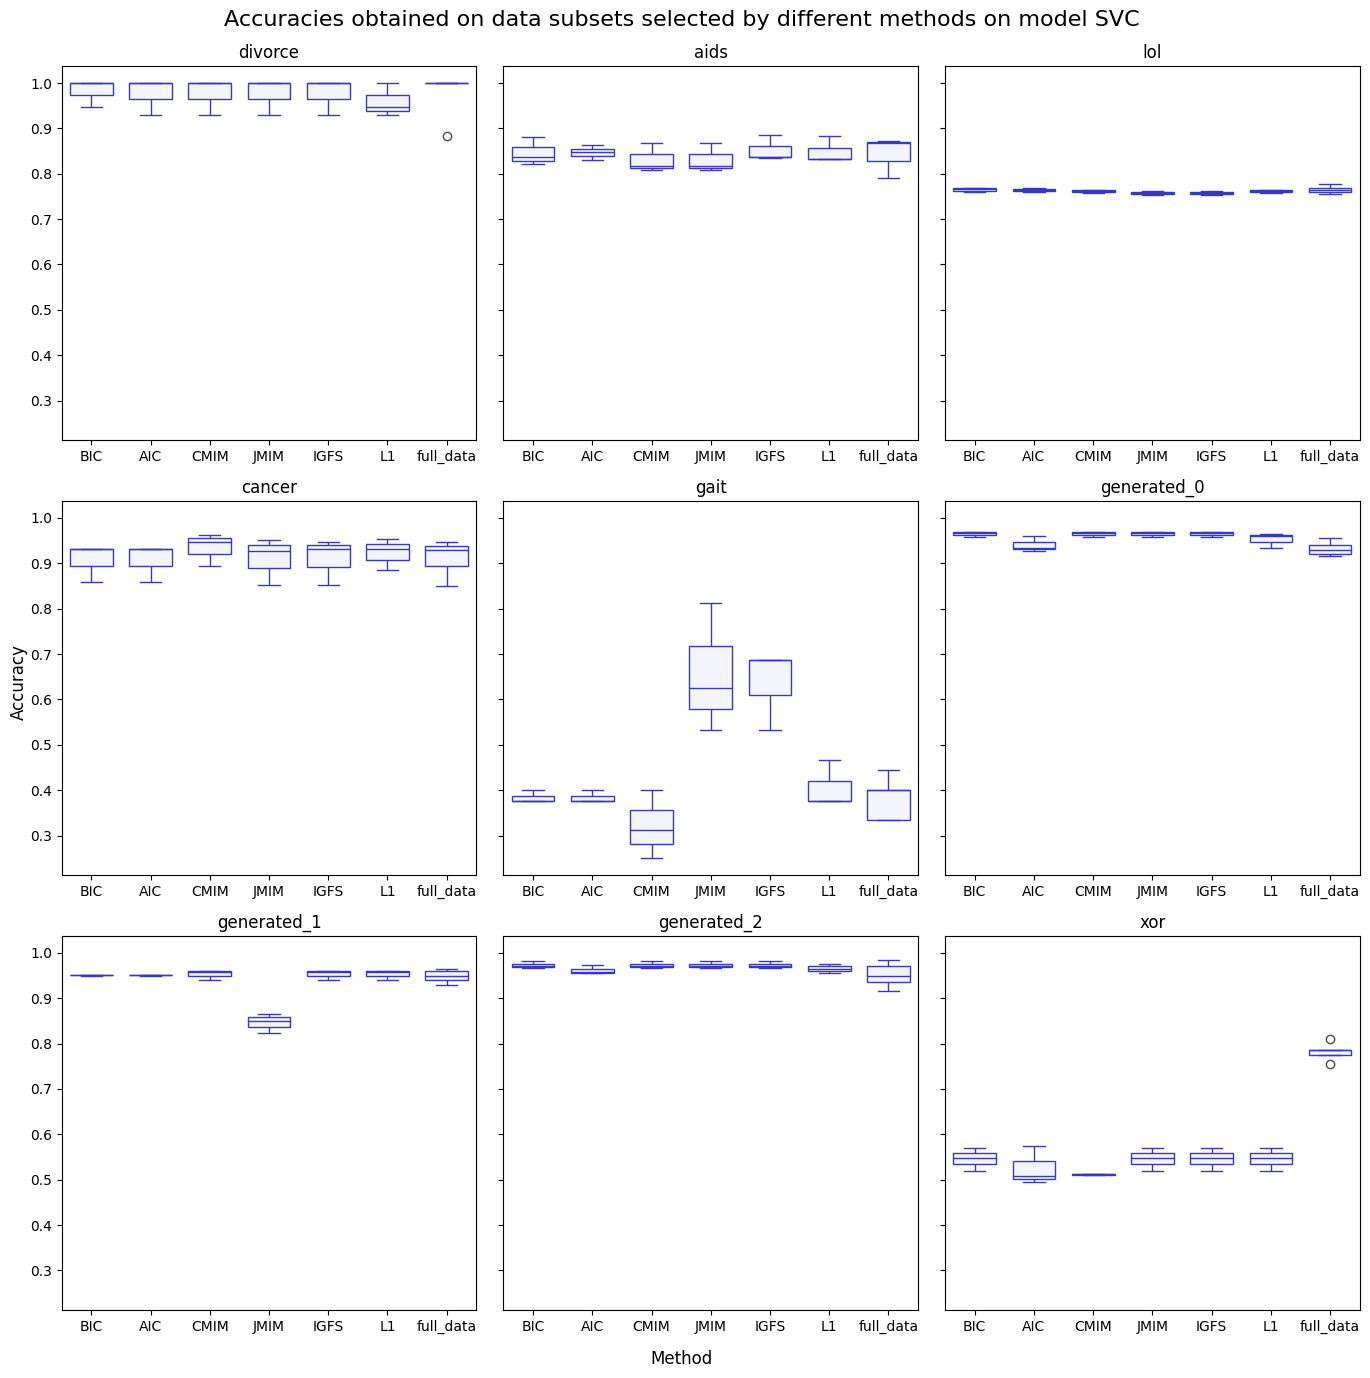

In [4]:
accuracy_scores = evaluate_feature_selection(data, relevant_features, SVC)
plot_all_datasets(accuracy_scores, model_name="SVC")

Processing dataset xor: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


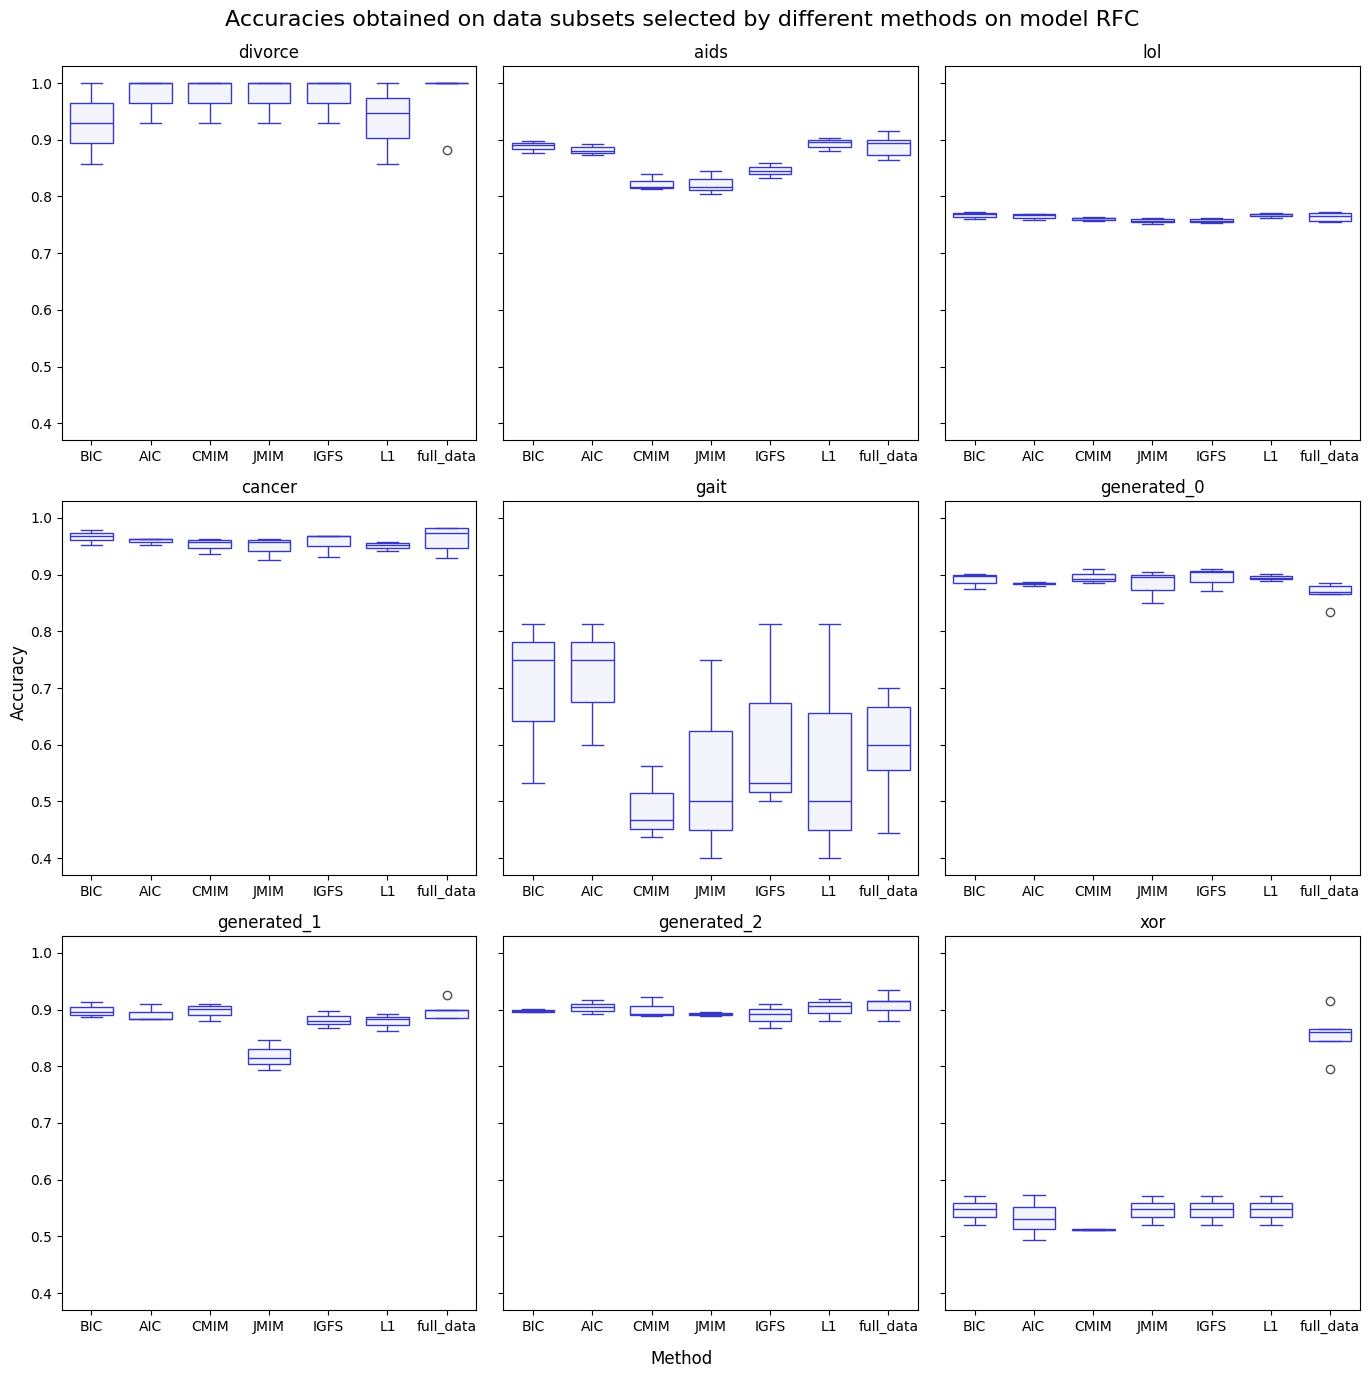

In [6]:
accuracy_scores = evaluate_feature_selection(data, relevant_features, RandomForestClassifier, max_depth=5)
plot_all_datasets(accuracy_scores, model_name="RFC")

Processing dataset xor: 100%|██████████| 6/6 [00:00<00:00, 33.60it/s]


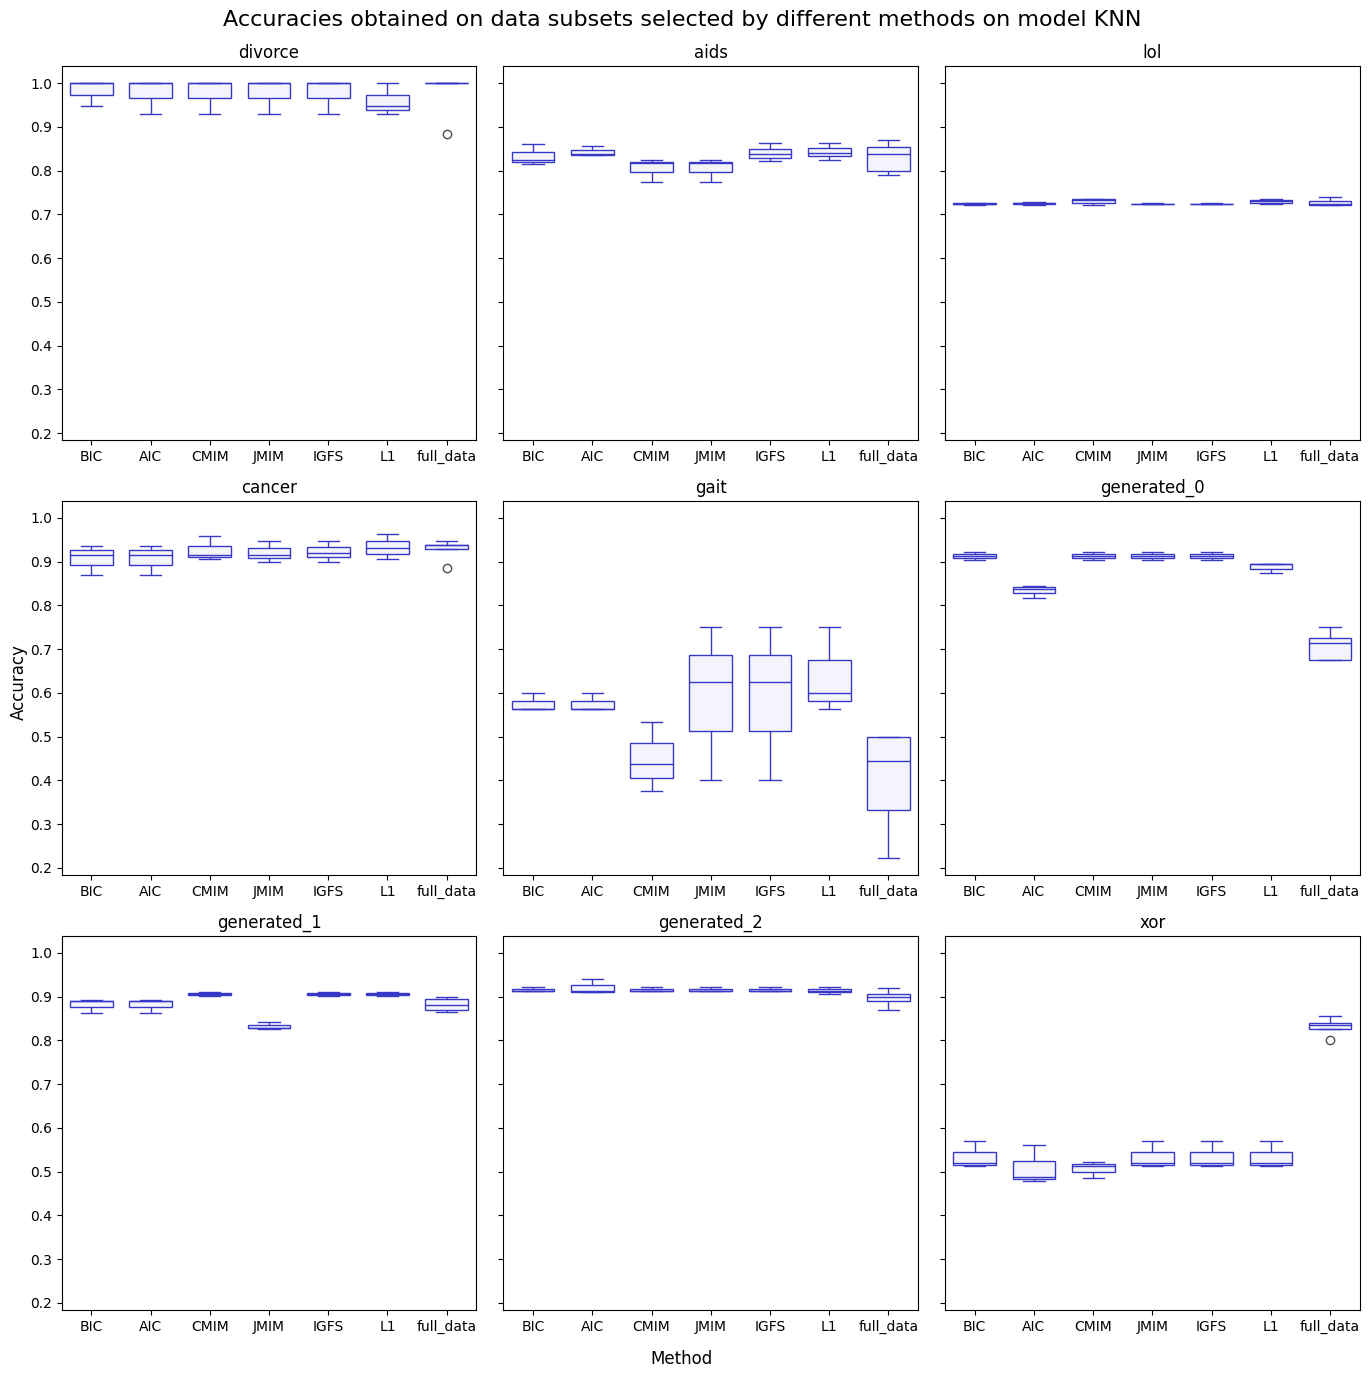

In [7]:
accuracy_scores = evaluate_feature_selection(data, relevant_features, KNeighborsClassifier)
plot_all_datasets(accuracy_scores, model_name="KNN")

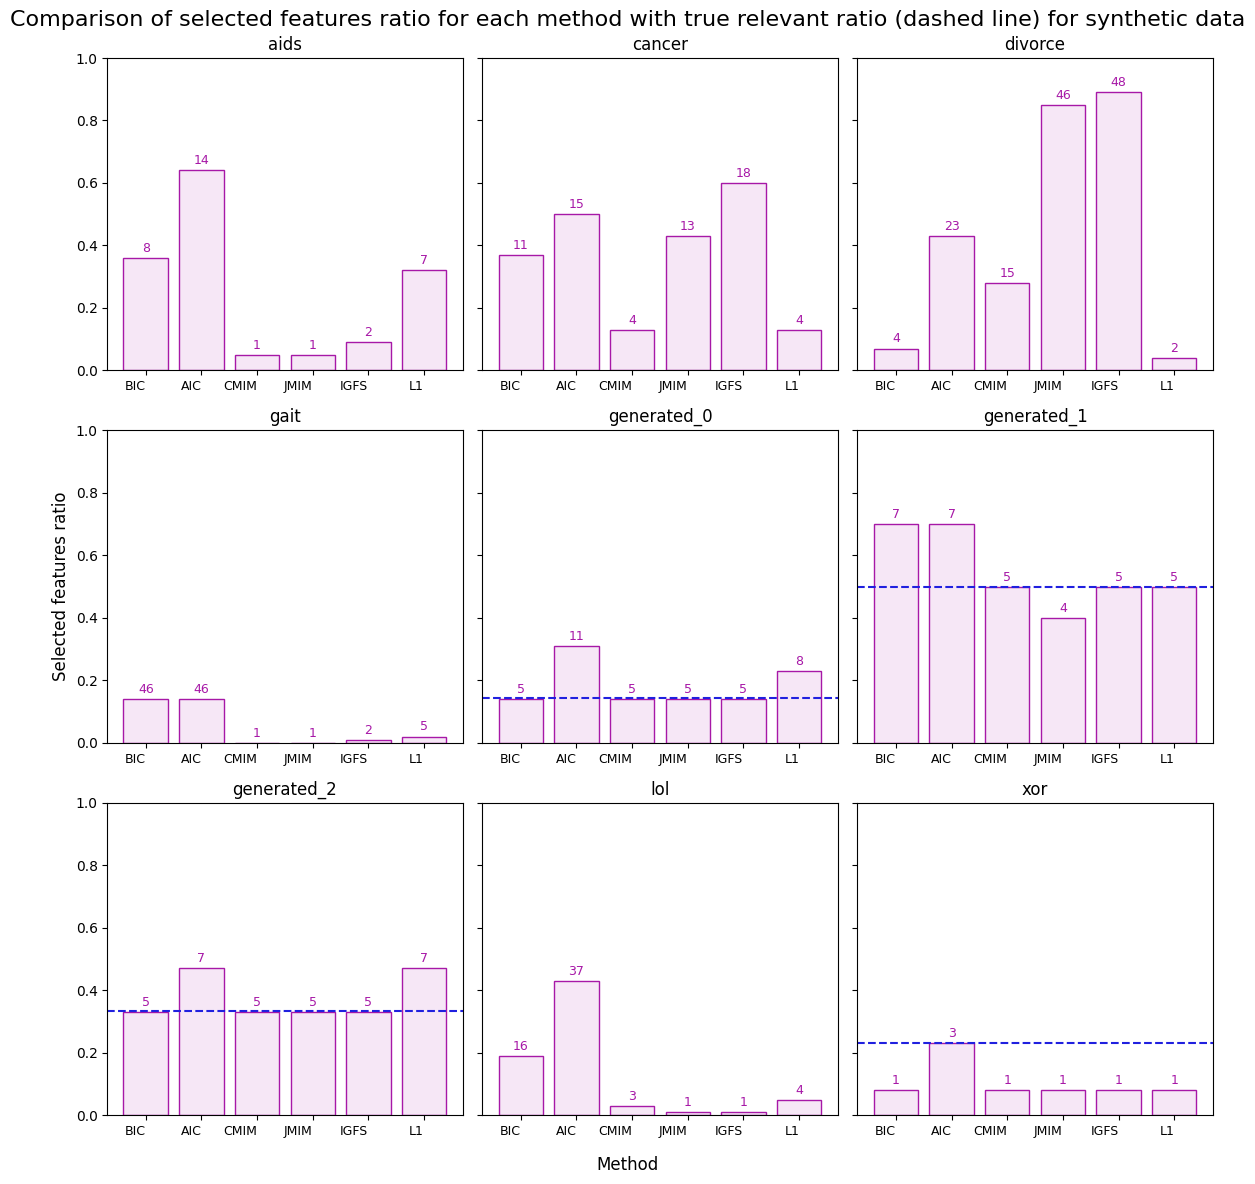

In [8]:
plot_n_features_ratio(process_generated_data_results(data, relevant_features))